In [0]:
import numpy as np
import cv2
import os
from scipy import ndimage
import matplotlib.pyplot as plt
from numpy import arctan2, fliplr, flipud


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp "/content/gdrive/My Drive/Colab Notebooks/others/lena.jpg" lena.jpg

In [4]:
!ls

gdrive	lena.jpg  sample_data


In [5]:
img = cv2.imread('lena.jpg',0)
img.shape

(400, 400)

In [0]:
# do padding if image is not square

def pad_image_for_square( img ):
    (rows, cols, dim) = img.shape
    resize_dim = max( rows, cols)
    pad_row = resize_dim - rows
    pad_col = resize_dim - cols
    img = np.pad(img, ((0,pad_row), (0, pad_col), (0,0)), 'constant', constant_values=0)
    return img

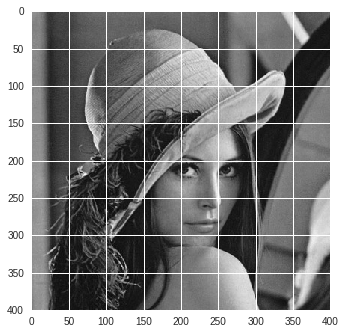

In [7]:
plt.imshow(img,cmap="gray")
plt.show()

In [0]:
def gradient(image):
    k_y = np.array([[-1,0,1]])
    k_x = np.array([[-1], [0], [1]])
    gx = ndimage.convolve(image, k_x, mode='constant', cval=1.0)
    gy = ndimage.convolve(image, k_y, mode='constant', cval=1.0)
    
    return gx, gy

In [0]:
gx, gy = gradient(img)

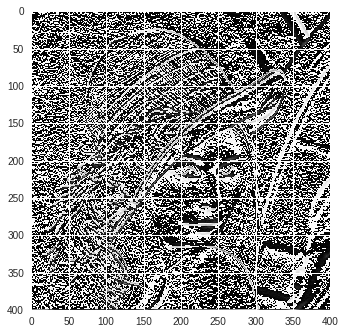

In [10]:
plt.imshow(gx,cmap=plt.cm.gray)
plt.show()

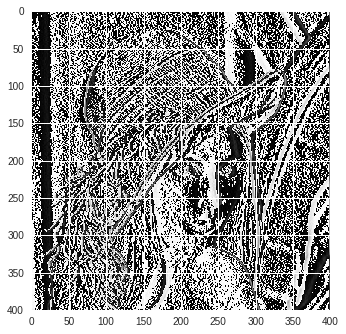

In [11]:
plt.imshow(gy,cmap=plt.cm.gray)
plt.show()

In [0]:
def magnitude_and_theta(gx,gy):
    
    magnitude = np.sqrt(gx**2 + gy**2)
    magnitude = magnitude.astype(int)
    theta = (arctan2(gy, gx) * 180 / np.pi) % 360
    theta = theta.astype(int)
    return magnitude, theta

In [0]:
m, theta = magnitude_and_theta(gx,gy)

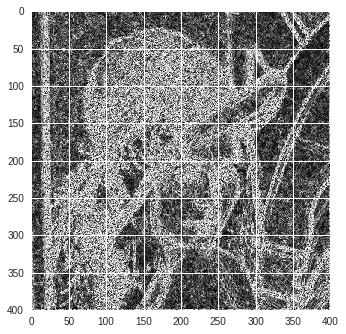

In [14]:
plt.imshow(m,cmap=plt.cm.gray)
plt.show()

In [0]:
cell_direction = m[:8, :8]
cell_magnitude = theta[:8, :8]

In [0]:
hist_bins = np.array([0,20,40,60,80,100,120,140,160])

In [0]:
def cell_histogram(cell_direction, cell_magnitude, hist_bins):
    cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
            diff = np.abs(curr_direction - hist_bins)
            min_idx = np.argmin(diff) #return minimum difference
            min_2nd =  np.argmin(np.partition(diff,1)[1])
            
            if diff[min_idx] == 0:
                cell_hist[min_idx] += curr_magnitude
            
            else:
               #linear interpolation
                diff_1 =  np.abs(curr_direction - hist_bins[min_idx])
                diff_2 =  np.abs(curr_direction - hist_bins[min_2nd])
                cell_hist[min_idx] += (diff_1/(diff_1+diff_2)) * curr_magnitude 
                cell_hist[min_2nd] += (diff_2/(diff_1+diff_2)) * curr_magnitude 
                
    return cell_hist 

In [0]:
# ref: https://github.com/ahmedfgad/HOGNumPy/blob/master/HOG.py
def hog_cell_hist(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = np.abs(curr_direction - hist_bins)
            
            if curr_direction < hist_bins[0]:
                first_bin_idx = 0
                second_bin_idx = hist_bins.size-1
            elif curr_direction > hist_bins[-1]:
                first_bin_idx = hist_bins.size-1
                second_bin_idx = 0
            else:
                first_bin_idx = np.where(diff == np.min(diff))[0][0]
                temp = hist_bins[[(first_bin_idx-1)%hist_bins.size, (first_bin_idx+1)%hist_bins.size]]
                temp2 = np.abs(curr_direction - temp)
                res = np.where(temp2 == np.min(temp2))[0][0]
                if res == 0 and first_bin_idx != 0:
                    second_bin_idx = first_bin_idx-1
                else:
                    second_bin_idx = first_bin_idx+1
            
            first_bin_value = hist_bins[first_bin_idx]
            second_bin_value = hist_bins[second_bin_idx]
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (np.abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (np.abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
        return HOG_cell_hist

In [19]:
concat_hist = []
cell_direction = m[:8, :8]
cell_magnitude = theta[:8, :8]

hist1 = cell_histogram(cell_direction,cell_magnitude,hist_bins)
hist2 = hog_cell_hist(cell_direction, cell_magnitude, hist_bins)
print(hist1)
print(hist2)
print("Should be same!")

[2733.    0.    0.    0.    0.    0.    0.    0.    0.]
[ 59. 180.   0.   0.   0.   0.   0.   0.   0.]
Should be same!


In [20]:
print(cell_direction," ---\n", cell_magnitude, " ---\n", hist_bins)

[[6 4 4 5 5 6 6 6]
 [4 1 1 2 4 4 4 5]
 [4 1 2 1 2 2 2 5]
 [5 1 2 3 1 1 3 5]
 [5 2 2 2 2 2 4 5]
 [3 3 4 3 3 2 4 5]
 [2 2 2 2 1 0 4 5]
 [2 2 0 1 1 3 7 7]]  ---
 [[45  0 63 64 64  0  1  2]
 [89 90 89 89 89  0 45 68]
 [25  0  0 90  0 89 63 68]
 [25  0  0  0  0 89 71 68]
 [89  0  0 63 63 26 45 59]
 [89  0 89 33 33 26 63 53]
 [90 63  0 26 45  0 90 90]
 [89  0  0 45  0  0 33 45]]  ---
 [  0  20  40  60  80 100 120 140 160]


In [0]:
concat_hist = []
cell_direction = m[:8, :8]
cell_magnitude = theta[:8, :8]

hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
concat_hist.append(hist)

cell_direction = m[:8, 8:16]
cell_magnitude = theta[:8, 8:16]

hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
concat_hist.append(hist)

cell_direction = m[8:16, :8]
cell_magnitude = theta[8:16, :8]
hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
concat_hist.append(hist)

cell_direction = m[8:16, 8:16]
cell_magnitude = theta[8:16, 8:16]
hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
concat_hist.append(hist)

In [22]:
concat_hist

[array([2733.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([2321.05,   37.95,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ]),
 array([3161.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([2283.8,   83.2,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
           0. ])]

In [23]:
m.shape

(400, 400)

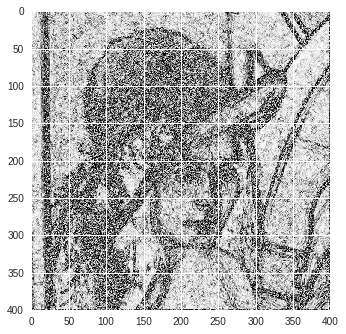

In [24]:
plt.imshow(m)

In [0]:
cell_direction = m[:8, :8]
import pdb; pdb.set_trace()
cell_direction.shape

--Return--
> <ipython-input-48-1f1340c1ccac>(2)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) m.shape
(400, 400)
(Pdb) m[:8, :8].shape
(8, 8)
(Pdb) m[8:8].shape
(0, 400)
(Pdb) m[:8, :8]
array([[6, 4, 4, 5, 5, 6, 6, 6],
       [4, 1, 1, 2, 4, 4, 4, 5],
       [4, 1, 2, 1, 2, 2, 2, 5],
       [5, 1, 2, 3, 1, 1, 3, 5],
       [5, 2, 2, 2, 2, 2, 4, 5],
       [3, 3, 4, 3, 3, 2, 4, 5],
       [2, 2, 2, 2, 1, 0, 4, 5],
       [2, 2, 0, 1, 1, 3, 7, 7]])
(Pdb) m[:8, :8].shape
(8, 8)
(Pdb) m[:8, :16].shape
(8, 16)
(Pdb)  m[:8, 8:16].shape
(8, 8)
(Pdb) c


(8, 8)

In [25]:
cell_direction = m[:8, :8]
cell_magnitude = theta[:8, :8]

hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
print(hist)

[2733.    0.    0.    0.    0.    0.    0.    0.    0.]


In [26]:
cell_direction = m[:8, 8:16]
cell_magnitude = theta[:8, 8:16]
print(cell_direction.shape, cell_magnitude.shape)
hist2 = cell_histogram(cell_direction,cell_magnitude,hist_bins)
print(hist2)

(8, 8) (8, 8)
[2321.05   37.95    0.      0.      0.      0.      0.      0.      0.  ]


In [27]:
cell_direction = m[8:16, :8]
cell_magnitude = theta[8:16, :8]
hist3 = cell_histogram(cell_direction,cell_magnitude,hist_bins)
print(hist3)

[3161.    0.    0.    0.    0.    0.    0.    0.    0.]


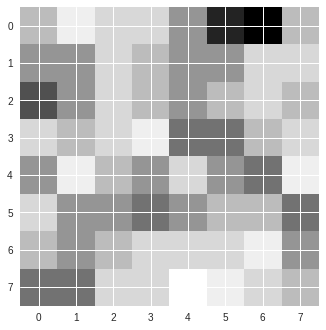

In [0]:
plt.imshow(m[8:16, :8])

In [0]:
m.shape

(400, 400)

In [0]:
400*400

160000

In [0]:
16000/ 8

2000.0

In [0]:
m_flatten = m.flatten()
theta_flatten = theta.flatten()
m_flatten.shape, theta_flatten.shape

((160000,), (160000,))

In [0]:
m_reshaped = m_flat.reshape((8, 20000))
theta_reshaped = theta_flatten.reshape((8, 20000))

m_reshaped.shape, theta_reshaped.shape

((8, 20000), (8, 20000))

In [0]:
cell_direction = m_reshaped[:8, :8]
cell_magnitude = theta_reshaped[:8, :8]

# not correct :( 
hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
print(hist)

[2988.4   32.6    0.     0.     0.     0.     0.     0.     0. ]


In [0]:
cell_direction = np.reshape(m_flatten[:64], (8, 8))
cell_magnitude = np.reshape(theta_flatten[:64], (8, 8))

#np.reshape(a, (3,-1))

cell_direction.shape, cell_magnitude.shape

((8, 8), (8, 8))

In [0]:
hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
print(hist)

[1076.3  287.7    0.     0.     0.     0.     0.     0.     0. ]


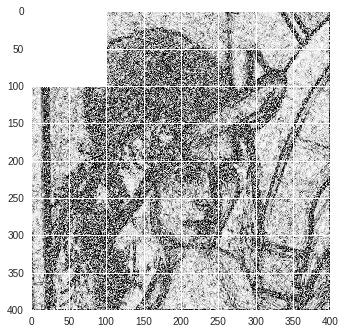

In [0]:
img_roi = m.copy()

a_th_row = 0
b_th_col = 0

row = 100
col = 100


for i in range(row):
    for j in range(col):
        img_roi[a_th_row+i, b_th_col+j] = 0

plt.imshow(img_roi)

In [0]:
def sliding_window(image, step, window):
	x_loc = []
	y_loc = []
	cells = []

	for y in range(0, image.shape[0], step):
		for x in range(0, image.shape[1], step):
			cells.append(image[y:y + window[1], x:x + window[0]])
			x_loc.append(x)
			y_loc.append(y)
	return x_loc, y_loc, cells


In [0]:
# set window size
(w, h) = 16, 16
# read image 
img = cv2.imread('lena.jpg',0)

# calc grad
gx, gy = gradient(img)

# magnitude and dir
m, theta = magnitude_and_theta(gx,gy)

#cell_direction = m[:8, :8]
#cell_magnitude = theta[:8, :8]
hist_bins = np.array([0,20,40,60,80,100,120,140,160])


In [57]:
x_pos, y_pos, cells = sliding_window(m, 8, (w, h))
len(x_pos), len(y_pos), len(cells), cells[0].shape

(2500, 2500, 2500, (16, 16))

In [65]:
print(x_pos[0], y_pos[0])
print(x_pos[1], y_pos[1])
print(x_pos[2], y_pos[2])
print(x_pos[3], y_pos[3])

print(x_pos[50], y_pos[50])

0 0
8 0
16 0
24 0
0 8


In [59]:
# put all hists here
concat_hist = []

for (x, y, cell) in zip(x_pos, y_pos, cells):
    cell_dir = cell
    cell_theta = theta[y:y + h, x:x + w]
    #print(cell_dir.shape, cell_theta.shape)
    hist = None
    hist = cell_histogram(cell_dir, cell_theta, hist_bins)
    concat_hist.append(hist)


IndexError: ignored

In [53]:
concat_hist[0]

array([2733.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])

In [54]:
concat_hist[1]

array([2321.05,   37.95,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
          0.  ,    0.  ])

In [55]:
concat_hist[2]

array([1853.7,  363.3,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ])